**MUHAMMAD FAHMI**

**FRESH GRADUATE ACADEMY**

**MACHINE LEARNING - IBM**

**NO. REGISTRASI : 0812180131-64**

**SUBMISSION 2 : MEMBUAT MODEL MACHINE LEARNING DENGAN TIME SERIES**

# Import librari yang akan digunakan

In [11]:
import numpy as np
import pandas as pd

import os
for dirname, _, filenames in os.walk('household.txt'):
  for filename in filenames:
    print(os.path.join(dirname, filename))

In [12]:
import tensorflow as tf
from keras.layers import Dropout
from keras.layers import LSTM

from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

# **Import data yang digunakan**

In [13]:
# karena data berbentuk txt, maka data diubah ke bentuk csv
df = pd.read_csv('household.txt', sep=';',
                 parse_dates={'dt' : ['Date', 'Time']}, infer_datetime_format=True,
                 low_memory=False, na_values=['nan', '?'], index_col='dt')

In [14]:
df.shape

(2075259, 7)

In [15]:
# Cek data karena ada yang 'NaN'
df.isnull().sum()

Global_active_power      25979
Global_reactive_power    25979
Voltage                  25979
Global_intensity         25979
Sub_metering_1           25979
Sub_metering_2           25979
Sub_metering_3           25979
dtype: int64

In [16]:
# Bersihkan Nan Data
df = df.fillna(df.mean())
df.isnull().sum()

Global_active_power      0
Global_reactive_power    0
Voltage                  0
Global_intensity         0
Sub_metering_1           0
Sub_metering_2           0
Sub_metering_3           0
dtype: int64

# **Visualisasi Data**

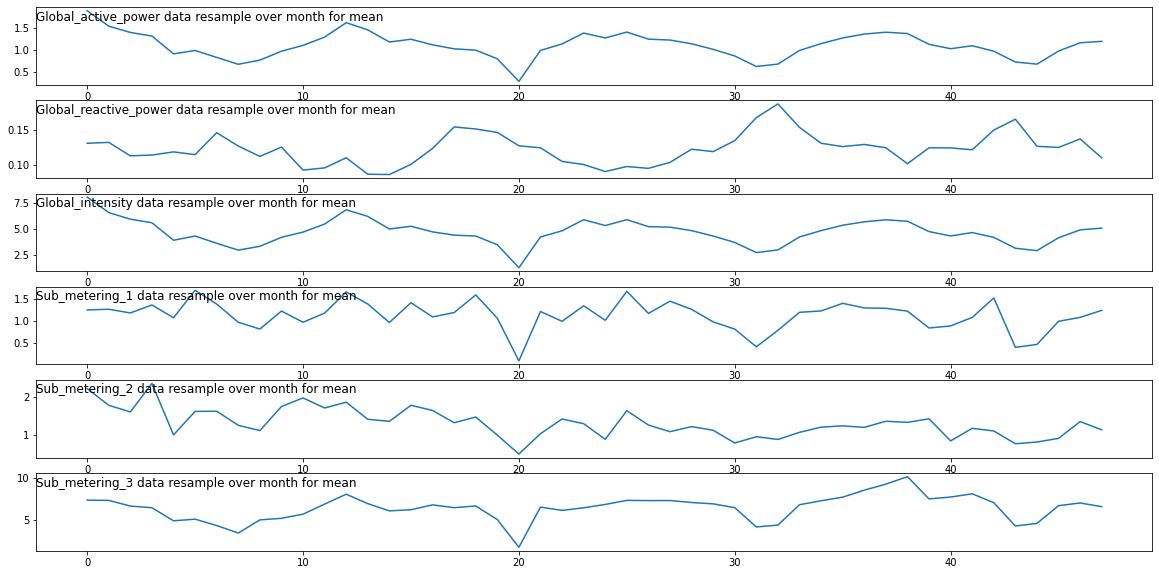

In [17]:
import matplotlib.pyplot as plt

i = 1
cols=[0, 1, 3, 4, 5, 6]
plt.figure(figsize=(20, 10))
for col in cols:
  plt.subplot(len(cols), 1, i)
  plt.plot(df.resample('M').mean().values[:, col])
  plt.title(df.columns[col] + ' data resample over month for mean', y=0.75, loc='left')
  i += 1
plt.show()

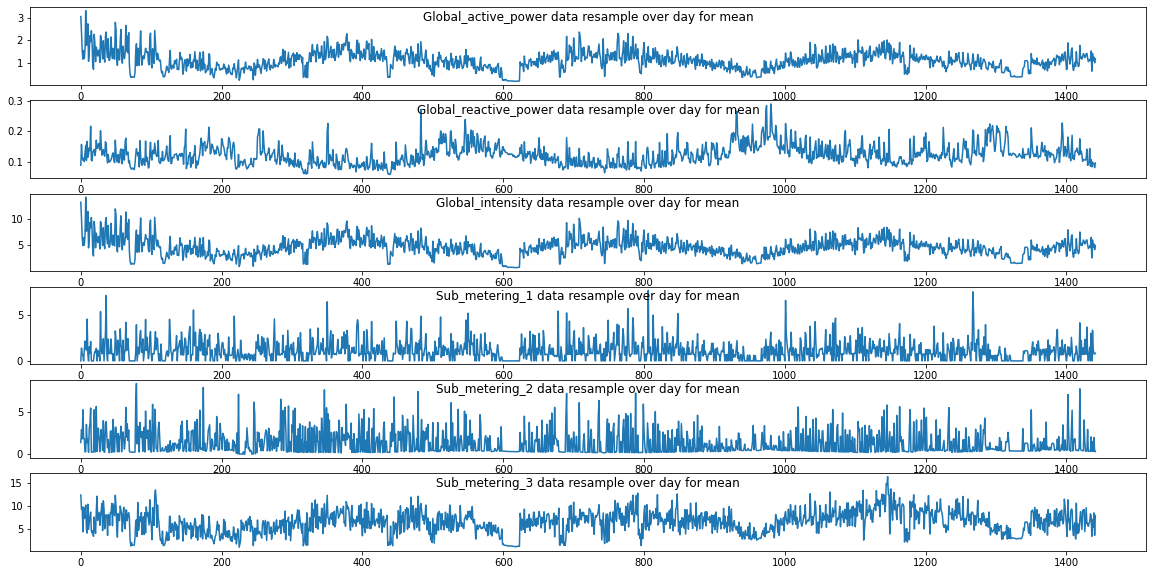

In [18]:
i = 1
cols=[0, 1, 3, 4, 5, 6]
plt.figure(figsize=(20, 10))
for col in cols:
  plt.subplot(len(cols), 1, i)
  plt.plot(df.resample('D').mean().values[:, col])
  plt.title(df.columns[col] + ' data resample over day for mean', y=0.75, loc='center')
  i += 1
plt.show()

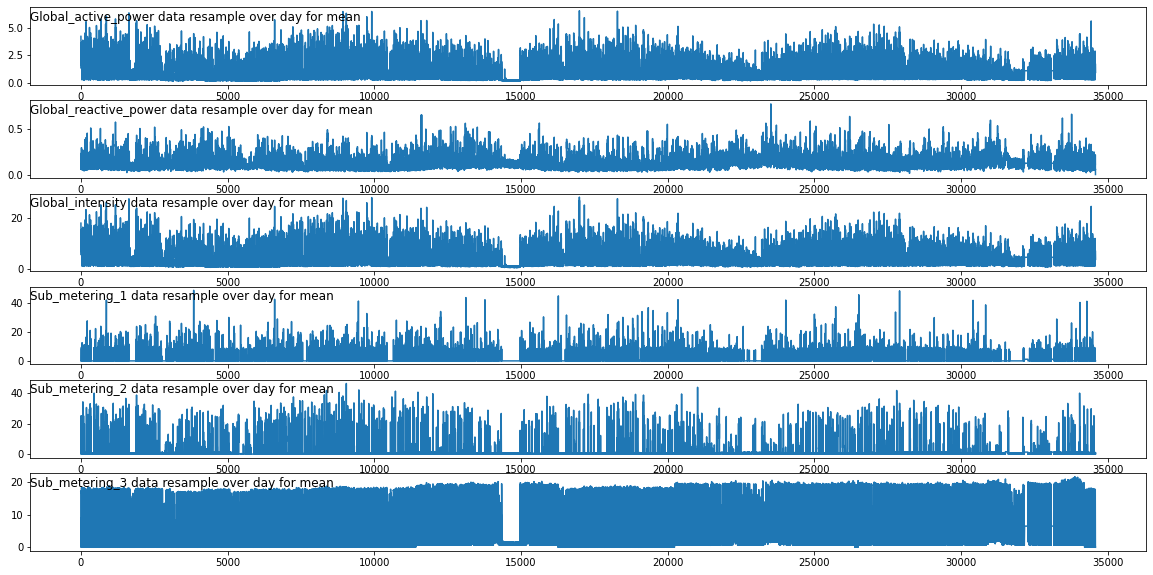

In [19]:
i = 1
cols=[0, 1, 3, 4, 5, 6]
plt.figure(figsize=(20, 10))
for col in cols:
  plt.subplot(len(cols), 1, i)
  plt.plot(df.resample('H').mean().values[:, col])
  plt.title(df.columns[col] + ' data resample over day for mean', y=0.75, loc='left')
  i += 1
plt.show()

In [20]:
df.corr()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
Global_active_power,1.000000,0.247017,-0.399762,0.998889,0.484401,0.434569,0.638555
Global_reactive_power,0.247017,1.000000,-0.112246,0.266120,0.123111,0.139231,0.089617
Voltage,-0.399762,-0.112246,1.000000,-0.411363,-0.195976,-0.167405,-0.268172
Global_intensity,0.998889,0.266120,-0.411363,1.000000,0.489298,0.440347,0.626543
Sub_metering_1,0.484401,0.123111,-0.195976,0.489298,1.000000,0.054721,0.102571
Sub_metering_2,0.434569,0.139231,-0.167405,0.440347,0.054721,1.000000,0.080872
Sub_metering_3,0.638555,0.089617,-0.268172,0.626543,0.102571,0.080872,1.000000


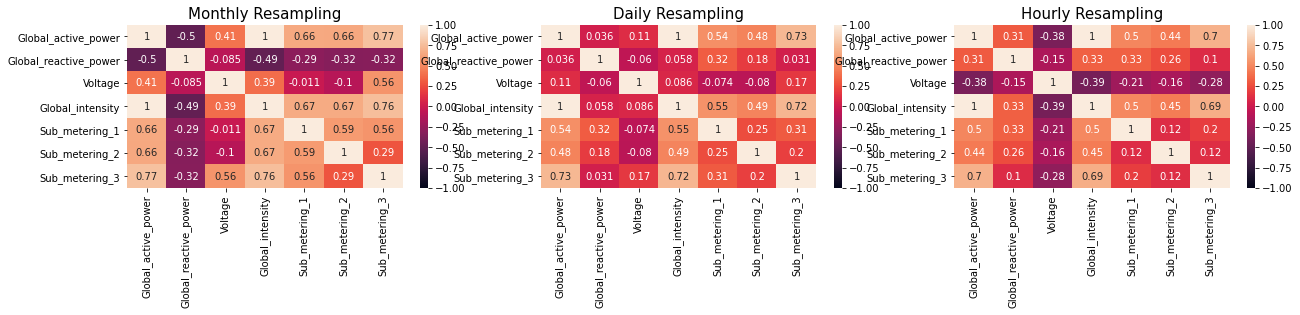

In [21]:
import seaborn as sns
f= plt.figure(figsize=(21, 3))

ax=f.add_subplot(131)
dfm = df.resample('M').mean()
sns.heatmap(dfm.corr(), vmin=-1, vmax=1, annot=True)
plt.title('Monthly Resampling', size=15)

ax=f.add_subplot(132)
dfm = df.resample('D').mean()
sns.heatmap(dfm.corr(), vmin=-1, vmax=1, annot=True)
plt.title('Daily Resampling', size=15)

ax=f.add_subplot(133)
dfm = df.resample('H').mean()
sns.heatmap(dfm.corr(), vmin=-1, vmax=1, annot=True)
plt.title('Hourly Resampling', size=15)
plt.show()

# **Membuat Model Machine Learning**

In [22]:
df_resample = df.resample('h').mean()
df_resample.shape

(34589, 7)

In [24]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(df_resample)
df_scaled =pd.DataFrame(scaled)

In [26]:
df_resample["Target"] = df_resample.Global_active_power.shift(-1)
df_resample = df_resample.iloc[:-1,:]

In [27]:
df_resample.tail()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,Target
dt,,,,,,,,
2010-11-26 16:00:00,1.067933,0.215633,240.457833,4.610000,0.0,0.950000,0.000000,1.725900
2010-11-26 17:00:00,1.725900,0.061400,237.069667,7.216667,0.0,0.000000,12.866667,1.573467
2010-11-26 18:00:00,1.573467,0.053700,237.531833,6.620000,0.0,0.000000,0.000000,1.659333
2010-11-26 19:00:00,1.659333,0.060033,236.741000,7.056667,0.0,0.066667,0.000000,1.163700
2010-11-26 20:00:00,1.163700,0.061167,239.396000,4.913333,0.0,1.066667,0.000000,0.934667


In [28]:
df_resample.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,Target
dt,,,,,,,,
2006-12-16 17:00:00,4.222889,0.229000,234.643889,18.100000,0.0,0.527778,16.861111,3.632200
2006-12-16 18:00:00,3.632200,0.080033,234.580167,15.600000,0.0,6.716667,16.866667,3.400233
2006-12-16 19:00:00,3.400233,0.085233,233.232500,14.503333,0.0,1.433333,16.683333,3.268567
2006-12-16 20:00:00,3.268567,0.075100,234.071500,13.916667,0.0,0.000000,16.783333,3.056467
2006-12-16 21:00:00,3.056467,0.076667,237.158667,13.046667,0.0,0.416667,17.216667,2.200133


**Memisahkan Data Train dan Test**

In [47]:
values = df_resample.values
num_train = round(34589 * 0.2)

train = values[num_train:, :]
test = values[:num_train, :]

X_train, y_train = train[:,1:], train[:,0]
X_test, y_test = test[:,1:], test[:,0]

In [48]:
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

In [49]:
print(X_train.shape,y_train.shape,X_test.shape,y_test.shape)

(27670, 1, 7) (27670,) (6918, 1, 7) (6918,)


In [50]:
model = tf.keras.Sequential()
initializer = tf.keras.initializers.HeNormal()
model.add(tf.keras.layers.LSTM(100, activation='relu', kernel_initializer=initializer,
                               input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(1))



In [54]:
optimizer = tf.keras.optimizers.SGD(lr=1.0000e-04, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(), 
              optimizer=optimizer, 
              metrics=["mae"])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [55]:
history = model.fit(X_train, y_train, epochs=50, batch_size=128, validation_data=(X_test, y_test),
                    shuffle=False)

Epoch 1/50
217/217 [==============================] - 3s 7ms/step - loss: 7.3775 - mae: 7.8422 - val_loss: 0.2649 - val_mae: 0.6647
Epoch 2/50
217/217 [==============================] - 1s 6ms/step - loss: 0.2568 - mae: 0.5723 - val_loss: 0.2020 - val_mae: 0.5648
Epoch 3/50
217/217 [==============================] - 1s 6ms/step - loss: 0.2006 - mae: 0.4955 - val_loss: 0.1795 - val_mae: 0.3953
Epoch 4/50
217/217 [==============================] - 1s 5ms/step - loss: 0.1470 - mae: 0.4118 - val_loss: 0.1457 - val_mae: 0.3331
Epoch 5/50
217/217 [==============================] - 1s 5ms/step - loss: 0.1152 - mae: 0.3545 - val_loss: 0.0967 - val_mae: 0.2854
Epoch 6/50
217/217 [==============================] - 1s 6ms/step - loss: 0.0980 - mae: 0.3201 - val_loss: 0.0613 - val_mae: 0.2289
Epoch 7/50
217/217 [==============================] - 1s 5ms/step - loss: 0.0942 - mae: 0.3097 - val_loss: 0.0632 - val_mae: 0.2048
Epoch 8/50
217/217 [==============================] - 1s 5ms/step - loss: 0.

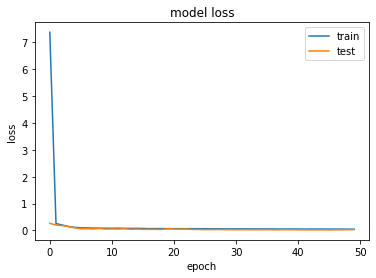

In [56]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

**Buat Prediksi**

In [57]:
y_predic = model.predict(X_test)
X_test.shape

(6918, 1, 7)

In [58]:
X_test = X_test.reshape(X_test.shape[0], 7)

In [59]:
inv_x = np.concatenate((y_predic, X_test[:, -6:]), axis=1)
inv_x = scaler.inverse_transform(inv_x)
inv_y_predic = inv_x[:,0]

y_test = y_test.reshape((len(y_test), 1))
inv_y = np.concatenate((y_test, X_test[:, -6:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

mae = np.abs(mean_squared_error(inv_y, inv_y_predic))
print('mae value : {}'.format(mae))

r2 = r2_score(inv_y, inv_y_predic)
print("R2 Score : {}".format(r2))

mae value : 2.4689656259555215
R2 Score : 0.9387344565042854
